In [1]:
import torch
import random
import os
import numpy as np
import pickle5 as pickle
from pathlib import Path
import torchvision.transforms as transforms
import torch.nn.functional as F

from torch.utils.data import DataLoader
import albumentations as A
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from utils.dataloaders import Birds_OneCluster, ACDCDataset, ShapeDataset, Birds_Dataset
# from utils.dataloaders import MDSDataset, LipstickDataset,
from utils.common import get_model

### ACDC inference

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_set = ACDCDataset('/home/e_radionova/Datasets/ACDC/train.h5', device)
val_set = ACDCDataset('/home/e_radionova/Datasets/ACDC/val.h5', device)

In [3]:
image_datasets = {
    'train': train_set , 'val': val_set
}

batch_size_train = 4
batch_size_val = batch_size_train

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size_train, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size_val, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 1188, 'val': 514}

In [4]:
seeds = [5, 7, 10, 11, 34]
idxs = [2, 3, 3, 2, 2]

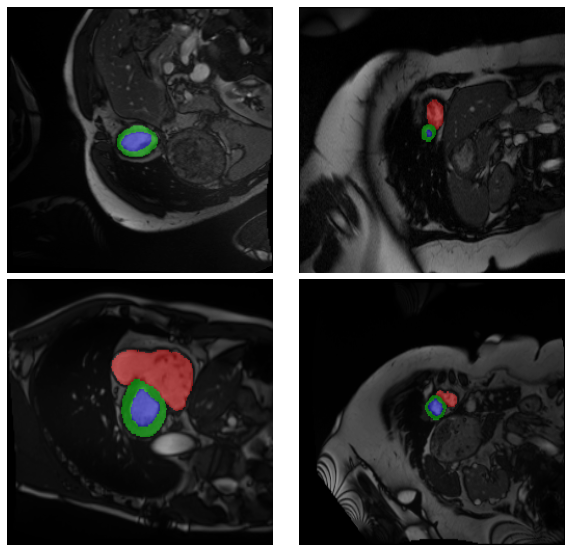

In [5]:
inputs = torch.Tensor()
masks = torch.Tensor()
for i in range(len(seeds)):
    random.seed(seeds[i])
    torch.manual_seed(seeds[i])
    torch.cuda.manual_seed_all(seeds[i])
    np.random.seed(seeds[i])
    inputs_1, masks_1 = next(iter(dataloaders['val']))
    inputs_1 = inputs_1[[idxs[i]]]
    masks_1 = masks_1[[idxs[i]]]
    inputs = torch.cat((inputs, inputs_1), dim=0)
    masks = torch.cat((masks, masks_1), dim=0)

n_pics_to_show = 4
half = int(n_pics_to_show/2)
fig, ax = plt.subplots(2, half, figsize=(10, 10))
plt.subplots_adjust(wspace=0.1,hspace=0.001)
for i in range(4):
    pic, label = inputs[i], masks[i]
    label_np = label.data.numpy().transpose(1, 2, 0)
    pic_np = pic.data.numpy().transpose(1, 2, 0)
    ax[i//half, i%half].imshow(pic_np, cmap='gray')
    ax[i//half, i%half].imshow(label_np, cmap='gray', alpha=0.4)
    ax[i//half, i%half].axis('off')

In [6]:
# SEED = 5 # 11 10 34
# # 10 idx - 3
# # 11 idx- 2
# # 34 idx- 2
# # 7 idx- 3
# # 5 idx- 2
# random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed_all(SEED)
# np.random.seed(SEED)

# n_pics_to_show = 4
# half = int(n_pics_to_show/2)
# inputs, masks = next(iter(dataloaders['val']))

# # inputs = inputs[[0,2,4,7]]
# # masks = masks[[0,2,4,7]]
# fig, ax = plt.subplots(2, half, figsize=(10, 10))
# plt.subplots_adjust(wspace=0.1,hspace=0.001)
# for i in range(n_pics_to_show):
#     pic, label = inputs[i], masks[i]
#     label_np = label.data.numpy().transpose(1, 2, 0)
#     pic_np = pic.data.numpy().transpose(1, 2, 0)
#     ax[i//half, i%half].imshow(pic_np, cmap='gray')
#     ax[i//half, i%half].imshow(label_np, cmap='gray', alpha=0.4)
#     ax[i//half, i%half].axis('off')

#### model

In [7]:
def get_model_out(inputs, model):
    with torch.no_grad():
        output = model(inputs.float().cuda())
        output = F.sigmoid(output)
        output = output.cpu().detach().numpy()
    return output

In [8]:
model_names = ['unet', 'attention-unet', 'lorck', 'def-convs', 'unet_init']
k_sizes = [3, 3, 3, 3, 7]

In [9]:
acdc_logs = Path('/home/e_radionova/PROJECT/optimal-kernels/IJCAI/weights/acdc')
acdc_weights_dct={
        'unet': 'unet_acdc_b8_2022-01-02T23:57.pth',
        'attention-unet': 'attention-unet_acdc_b8_2022-01-02T23:57.pth',
        'lorck': 'lorck_acdc_b8_2022-01-04T20:29.pth',
        'def-convs': 'def-convs_acdc_b8_2022-01-03T00:31.pth',
        'unet_init': 'unet_init_acdc_b8_with_k_size_7_2022-01-08T20:56.pth'
#         'unet_init': 'unet_init_acdc_b8_with_k_size_15_2022-01-07T22:53.pth'
}


In [10]:
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

dct_models = {}
dct_outputs = {}
for i in range(len(model_names)):    
    model = get_model(model_names[i], in_chs=1, out_chs=3, k_size=k_sizes[i])
    model = model.to(device)
    weight = acdc_logs / acdc_weights_dct[model_names[i]]
    model.load_state_dict(torch.load(weight))
    model.eval()
    
    outputs = get_model_out(inputs, model)
    
    dct_models[model_names[i]] = model
    dct_outputs[model_names[i]] = outputs

/home/e_radionova/anaconda3/envs/py37_torchh_last/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/e_radionova/anaconda3/envs/py37_torchh_last/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [11]:
# for i in range(outputs.shape[0]):
#     plt.imshow(outputs[i].transpose(1,2,0))
#     plt.show()    

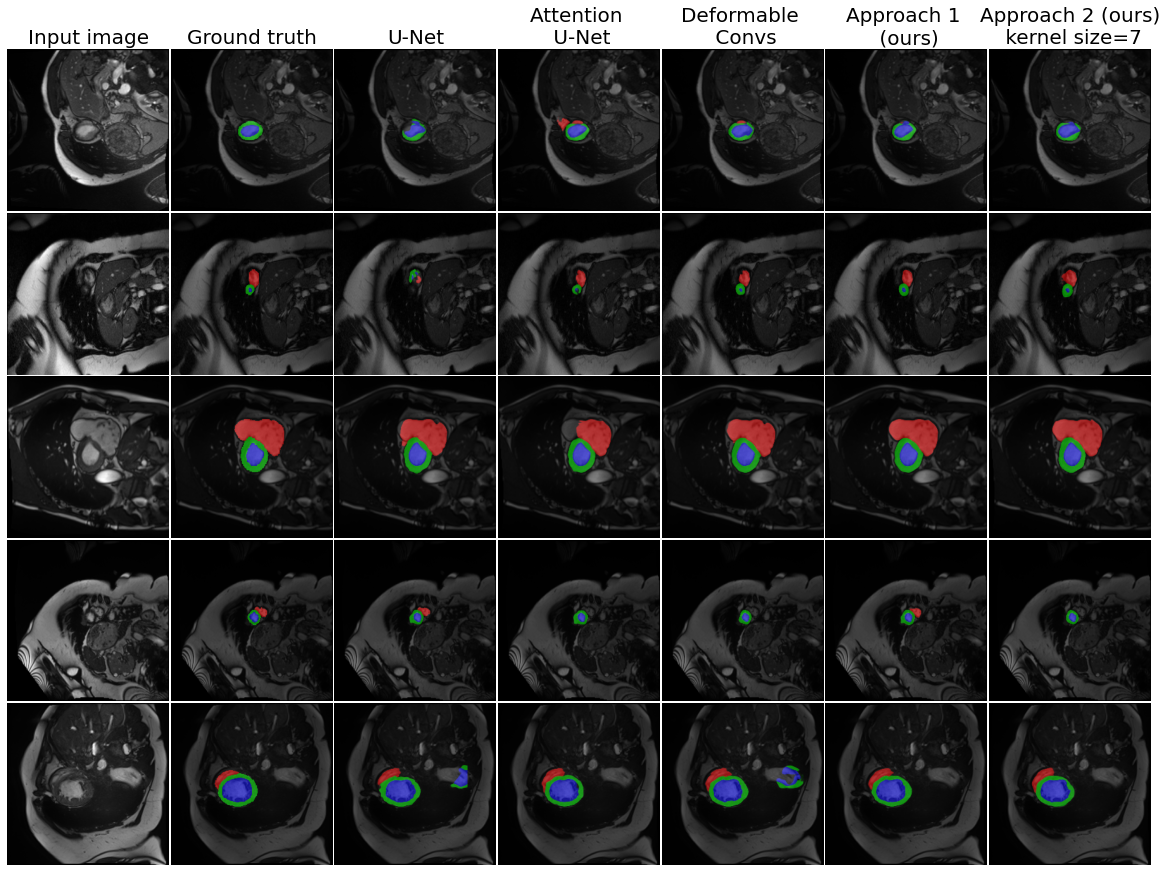

In [19]:
fig, ax = plt.subplots(5, 7, figsize=(20.5, 15))
plt.subplots_adjust(wspace=0.01,hspace=0.01)
alpha = 0.5
for i in range(5):
    ax[i, 0].imshow(inputs[i].permute(1,2,0), cmap='gray')
    ax[i, 0].axis('off')
    
    ax[i, 1].imshow(inputs[i].permute(1,2,0), cmap='gray')
    ax[i, 1].imshow(masks[i].permute(1,2,0), alpha=alpha)    
    ax[i, 1].axis('off')
    
    ax[i, 2].imshow(inputs[i].permute(1,2,0), cmap='gray')
    ax[i, 2].imshow(dct_outputs['unet'][i].transpose(1,2,0), alpha=alpha)
    ax[i, 2].axis('off')
    
    ax[i, 3].imshow(inputs[i].permute(1,2,0), cmap='gray')
    ax[i, 3].imshow(dct_outputs['attention-unet'][i].transpose(1,2,0), alpha=alpha)
    ax[i, 3].axis('off')
    
    ax[i, 4].imshow(inputs[i].permute(1,2,0), cmap='gray')
    ax[i, 4].imshow(dct_outputs['def-convs'][i].transpose(1,2,0), alpha=alpha)
    ax[i, 4].axis('off')
    
    ax[i, 5].imshow(inputs[i].permute(1,2,0), cmap='gray')
    ax[i, 5].imshow(dct_outputs['lorck'][i].transpose(1,2,0), alpha=alpha)
    ax[i, 5].axis('off')
    
    ax[i, 6].imshow(inputs[i].permute(1,2,0), cmap='gray')
    ax[i, 6].imshow(dct_outputs['unet_init'][i].transpose(1,2,0), alpha=alpha)
    ax[i, 6].axis('off')
    
    name_size=20
    ax[0, 0].set_title('Input image', fontsize=name_size)
    ax[0, 1].set_title('Ground truth', fontsize=name_size)
    ax[0, 2].set_title('U-Net', fontsize=name_size)
    ax[0, 3].set_title('Attention \n U-Net', fontsize=name_size)    
    ax[0, 4].set_title('Deformable \n Convs', fontsize=name_size)
    ax[0, 5].set_title('Approach 1 \n (ours)', fontsize=name_size)
    ax[0, 6].set_title('Approach 2 (ours)\n kernel size=7', fontsize=name_size)
plt.show()

In [20]:
fig.savefig('./imgs/acdc_25_01.png', dpi=100)   # save the figure to file
plt.close(fig)